# **PROYECTO DE INTELIGENCIA ARTIFICIAL 2024-2**


# **Primera Entrega**

In [1]:
#@title Importaciones (Siempre ejecutar esta celda)
from google.colab import drive
import os
import zipfile
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#@title Montar Drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/AI-2024-2/Proyecto'
os.listdir(project_path)

# Cargamos el archivo de texto con los nombres de las imagenes
txt_path = os.path.join(project_path, 'identity_CelebA.txt')
image_data = pd.read_csv(txt_path, delim_whitespace=True, header=None, names=['filename', 'id'])
#image_data=image_data.iloc[:10000,:]
print(image_data.head())
print(image_data.shape)


Mounted at /content/drive


<ipython-input-2-dc9c5381e312>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_data = pd.read_csv(txt_path, delim_whitespace=True, header=None, names=['filename', 'id'])


     filename    id
0  000001.jpg  2880
1  000002.jpg  2937
2  000003.jpg  8692
3  000004.jpg  5805
4  000005.jpg  9295
(202599, 2)


In [3]:
#@title Media de Fotos por ID
media=image_data.groupby('id').count().mean()
print(media)

filename    19.907537
dtype: float64


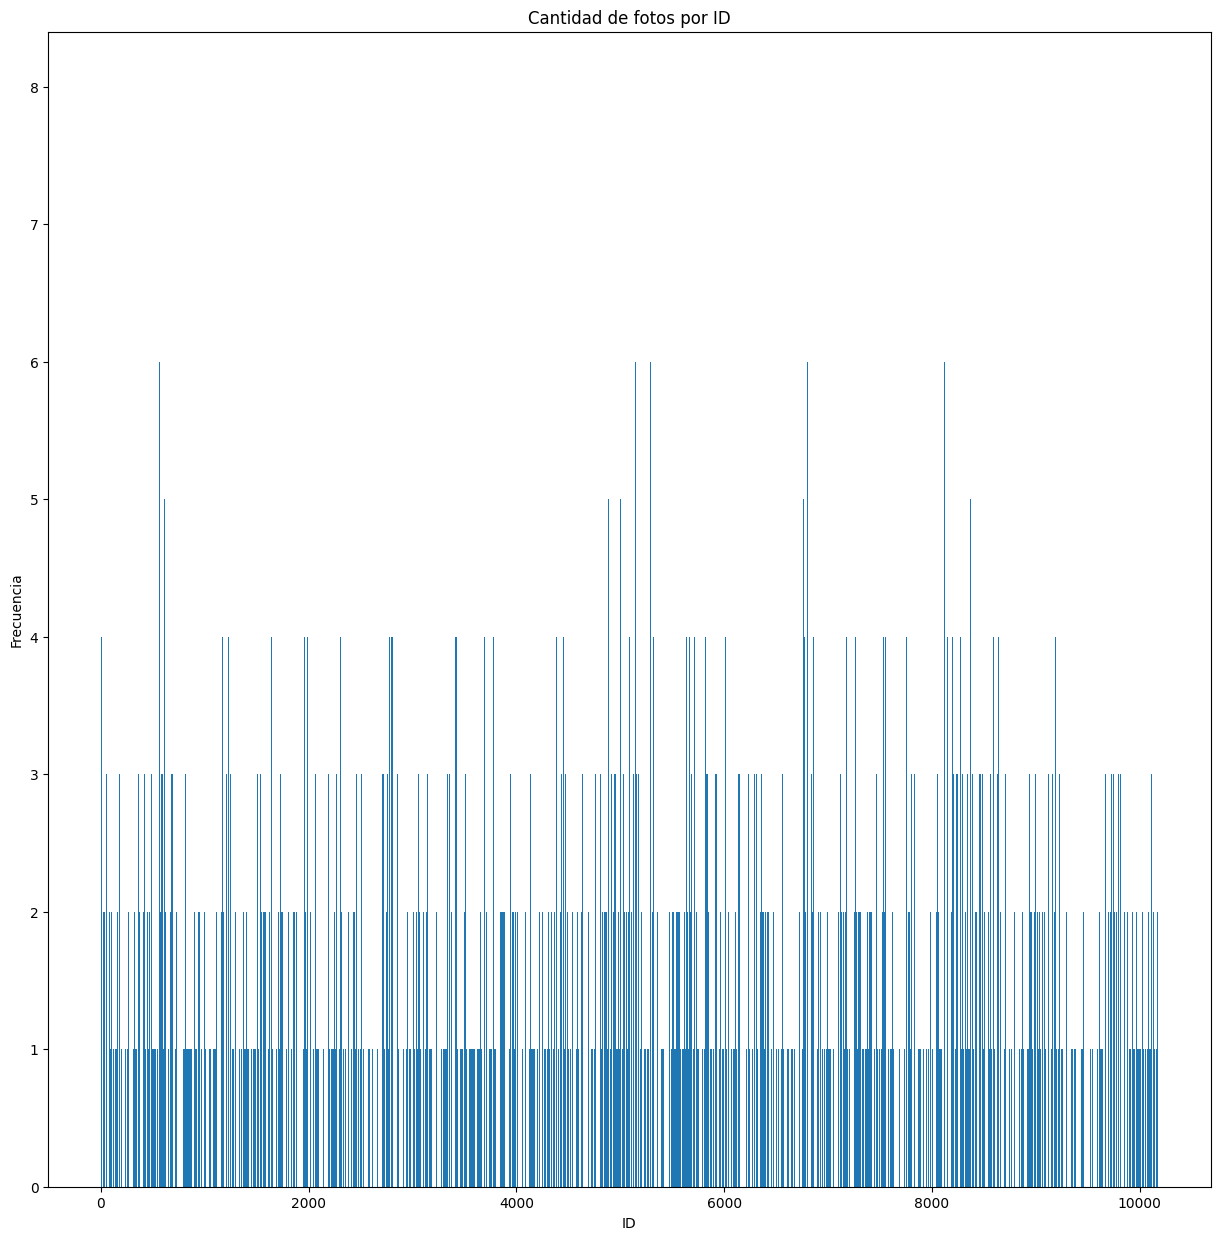

In [ ]:
plt.figure(figsize=(15, 15))
plt.hist(image_data.id, bins=10000)
plt.xlabel('ID')
plt.ylabel('Frecuencia')
plt.title('Cantidad de fotos por ID')
plt.show()

In [3]:
#@title Descomprimir archivos (Ejecutar una vez por sesion)
zip_path = os.path.join(project_path, 'img_align_celeba.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [4]:
#@title Cargar imágenes
def load_images(filenames):
    images = [np.array(Image.open(os.path.join('/content/dataset/img_align_celeba', filename))) for filename in filenames]
    return np.stack(images)

# Cargar todas las imágenes y convertirlas a un array 4D (número de imágenes, altura, anchura, canales)

##Solo se cargaran las imagenes de los primeros 1000 ids por limitaciones
image_data=image_data[image_data['id']<=1000]
images_array = load_images(image_data['filename'])
print(images_array.shape)


(21152, 218, 178, 3)


(28, 218, 178, 3)


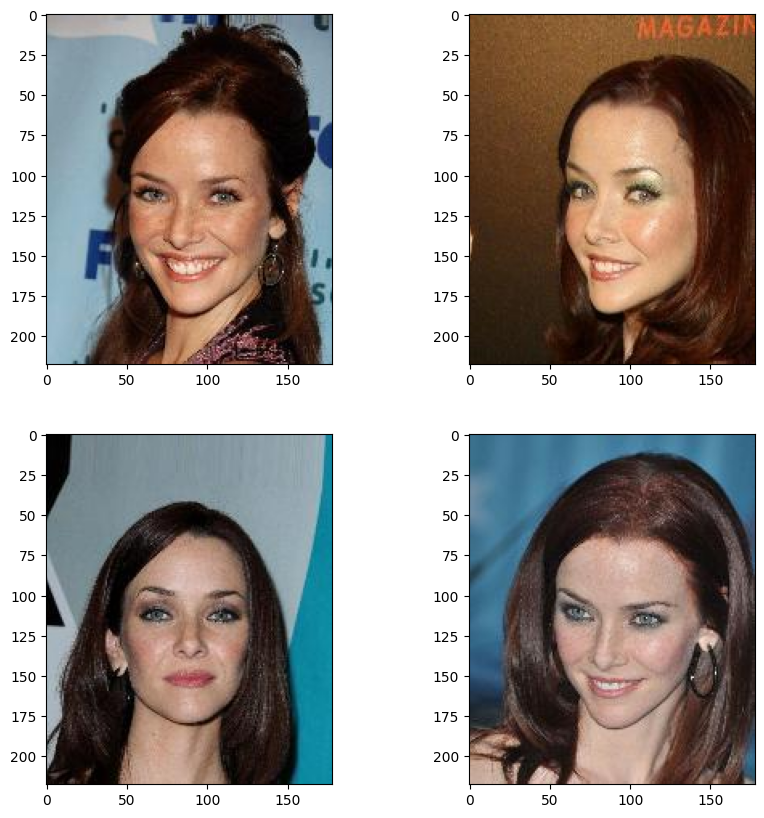

In [6]:
#@title Muestra Imagen
ims=image_data[image_data['id']==731]
images = load_images(ims['filename'])
print(images.shape)
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(images[0])
plt.subplot(2,2,2)
plt.imshow(images[1])
plt.subplot(2,2,3)
plt.imshow(images[2])
plt.subplot(2,2,4)
plt.imshow(images[3])

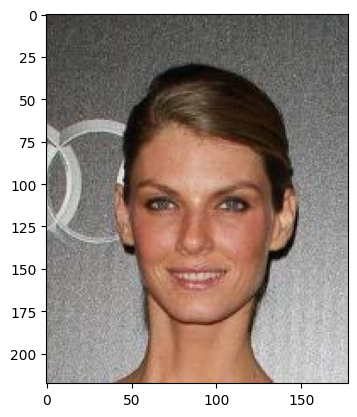

In [7]:
plt.imshow(images_array[24])

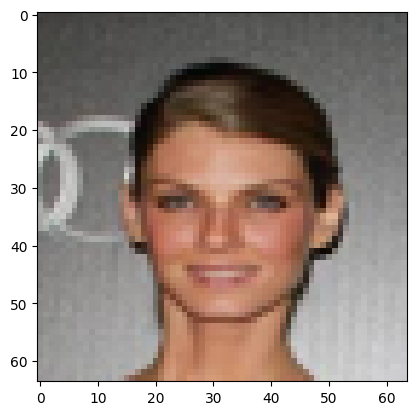

In [8]:
imgPrueba=Image.fromarray(images_array[24])
imgPrueba=imgPrueba.resize((64,64))
plt.imshow(imgPrueba)

# **SEGUNDA ENTREGA**

In [16]:
#@title Manipulacion de Imágenes y Definición del Dataset

## Redimensionar las imagenes y aplanarlas
resizedImages=[Image.fromarray(image).resize((64,64)) for image in images_array]
## Convertir a Grayscale
resizedImages=[image.convert('L') for image in resizedImages]
resizedImages=np.array(resizedImages)

oneDimages=np.array([np.array(image).flatten() for image in resizedImages])
print(oneDimages.shape)

(21152, 4096)


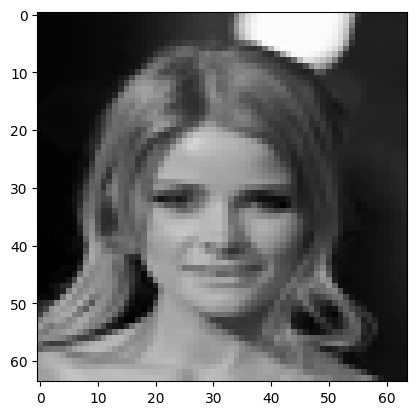

In [17]:
plt.imshow(resizedImages[0].reshape(64,64),cmap='gray')

In [19]:
#@title Estandarizar y reducir
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(oneDimages)

# Aplicar PCA
pca = PCA(n_components=400)
pca_data = pca.fit_transform(scaled_data)

# Aplicar TSNE
tsne = TSNE(n_components=2,perplexity=30)
tsne_data = tsne.fit_transform(scaled_data)

In [23]:
#@title Clasificacion PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import *

## PCA
X=pca_data
y=image_data['id']
##Se agrega stratify y para garantizar que haya al menos una etiqueta de cada una en testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

gnb=GaussianNB()
dtc=DecisionTreeClassifier(max_depth=10)
rfc=RandomForestClassifier(n_estimators=100,max_depth=10)
svc=SVC(kernel='rbf', gamma='scale')

gnb.fit(X_train,y_train)
dtc.fit(X_train,y_train)
rfc.fit(X_train,y_train)
svc.fit(X_train,y_train)

y_pred_gnb=gnb.predict(X_test)
y_pred_dtc=dtc.predict(X_test)
y_pred_rfc=rfc.predict(X_test)
y_pred_svc=svc.predict(X_test)

metrics = { 'GaussianNB': {}, 'DecisionTree': {}, 'RandomForest': {}, 'SVC': {} }

def calculate_metrics(y_test, y_pred, classifier_name):
  metrics[classifier_name]['accuracy'] = accuracy_score(y_test, y_pred)
  metrics[classifier_name]['recall'] = recall_score(y_test, y_pred, average='macro')
  metrics[classifier_name]['precision'] = precision_score(y_test, y_pred, average='macro')
  metrics[classifier_name]['f1_score'] = f1_score(y_test, y_pred, average='macro')

calculate_metrics(y_test, y_pred_gnb, 'GaussianNB')
calculate_metrics(y_test, y_pred_dtc, 'DecisionTree')
calculate_metrics(y_test, y_pred_rfc, 'RandomForest')
calculate_metrics(y_test, y_pred_svc, 'SVC')



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [24]:
print(metrics)

{'GaussianNB': {'accuracy': 0.15584620233217775, 'recall': 0.130825, 'precision': 0.23308852481419362, 'f1_score': 0.14584910644845395}, 'DecisionTree': {'accuracy': 0.006933501418216199, 'recall': 0.005791666666666666, 'precision': 0.002727072102271467, 'f1_score': 0.0017091722618438492}, 'RandomForest': {'accuracy': 0.017018594390167036, 'recall': 0.0130531746031746, 'precision': 0.010383999985960934, 'f1_score': 0.007509360524581481}, 'SVC': {'accuracy': 0.0991175543649543, 'recall': 0.0798892857142857, 'precision': 0.09170355529660408, 'f1_score': 0.06833240346237116}}


In [25]:
#@title Clasificador TSNE
## PCA
X=tsne_data
y=image_data['id']
##Se agrega stratify y para garantizar que haya al menos una etiqueta de cada una en testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

gnb2=GaussianNB()
dtc2=DecisionTreeClassifier(max_depth=10)
rfc2=RandomForestClassifier(n_estimators=100,max_depth=10)
svc2=SVC(kernel='rbf', gamma='scale')

gnb2.fit(X_train,y_train)
dtc2.fit(X_train,y_train)
rfc2.fit(X_train,y_train)
svc2.fit(X_train,y_train)

y_pred_gnb=gnb2.predict(X_test)
y_pred_dtc=dtc2.predict(X_test)
y_pred_rfc=rfc2.predict(X_test)
y_pred_svc=svc2.predict(X_test)

metrics2 = { 'GaussianNB': {}, 'DecisionTree': {}, 'RandomForest': {}, 'SVC': {} }

def calculate_metrics2(y_test, y_pred, classifier_name):
  metrics2[classifier_name]['accuracy'] = accuracy_score(y_test, y_pred)
  metrics2[classifier_name]['recall'] = recall_score(y_test, y_pred, average='macro',zero_division=0)
  metrics2[classifier_name]['precision'] = precision_score(y_test, y_pred, average='macro', zero_division=0)
  metrics2[classifier_name]['f1_score'] = f1_score(y_test, y_pred, average='macro', zero_division=0)

calculate_metrics2(y_test, y_pred_gnb, 'GaussianNB')
calculate_metrics2(y_test, y_pred_dtc, 'DecisionTree')
calculate_metrics2(y_test, y_pred_rfc, 'RandomForest')
calculate_metrics2(y_test, y_pred_svc, 'SVC')


In [26]:
print(metrics2)

{'GaussianNB': {'accuracy': 0.008036558462023322, 'recall': 0.006846031746031746, 'precision': 0.000351845737048462, 'f1_score': 0.0006575591189352234}, 'DecisionTree': {'accuracy': 0.017018594390167036, 'recall': 0.013657936507936508, 'precision': 0.014975107620444373, 'f1_score': 0.008142658776342735}, 'RandomForest': {'accuracy': 0.04238890639773085, 'recall': 0.036149603174603175, 'precision': 0.041185202806879, 'f1_score': 0.032166218996937716}, 'SVC': {'accuracy': 0.00961235423889064, 'recall': 0.0076146825396825385, 'precision': 0.0007168046801551717, 'f1_score': 0.0011701363187399277}}


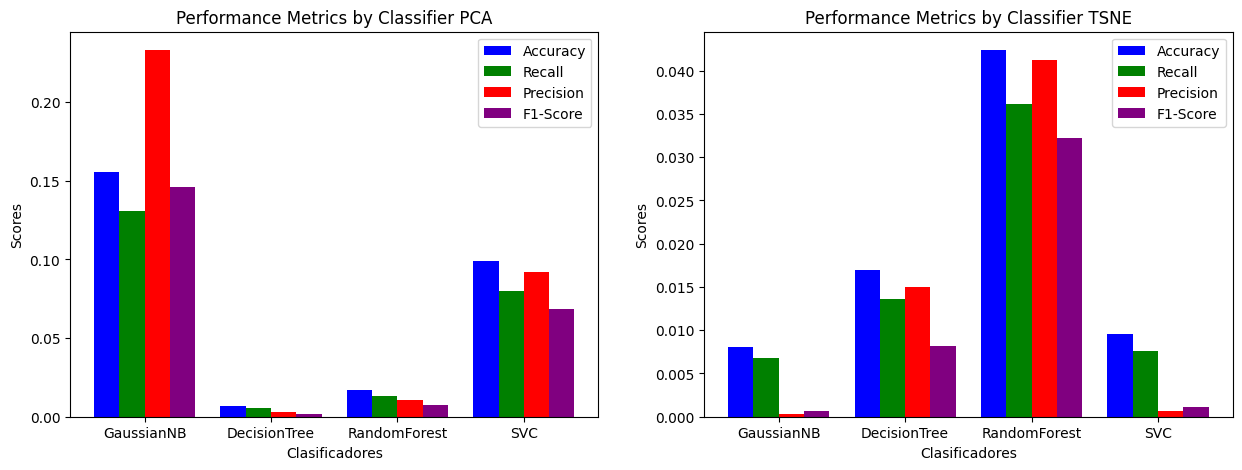

In [58]:
#@title Grafica Comparativa Clasificacion

# Listas para almacenar los nombres de los clasificadores y sus métricas
classifiers = list(metrics.keys())
accuracy = [metrics[clf]['accuracy'] for clf in classifiers]
recall = [metrics[clf]['recall'] for clf in classifiers]
precision = [metrics[clf]['precision'] for clf in classifiers]
f1_score = [metrics[clf]['f1_score'] for clf in classifiers]

x = np.arange(len(classifiers))

# Listas para almacenar los nombres de los clasificadores y sus métricas
classifiers2 = list(metrics2.keys())
accuracy2 = [metrics2[clf]['accuracy'] for clf in classifiers]
recall2 = [metrics2[clf]['recall'] for clf in classifiers]
precision2 = [metrics2[clf]['precision'] for clf in classifiers]
f1_score2 = [metrics2[clf]['f1_score'] for clf in classifiers]

x2 = np.arange(len(classifiers2))

# Ancho de las barras
width = 0.2

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# Añadir barras para cada métrica
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='blue')
plt.bar(x - 0.5*width, recall, width, label='Recall', color='green')
plt.bar(x + 0.5*width, precision, width, label='Precision', color='red')
plt.bar(x + 1.5*width, f1_score, width, label='F1-Score', color='purple')

# Añadir etiquetas y título
plt.xlabel('Clasificadores')
plt.ylabel('Scores')
plt.title('Performance Metrics by Classifier PCA')
plt.xticks(x, classifiers)
plt.legend()

plt.subplot(1, 2, 2)

# Añadir barras para cada métrica
plt.bar(x - 1.5*width, accuracy2, width, label='Accuracy', color='blue')
plt.bar(x - 0.5*width, recall2, width, label='Recall', color='green')
plt.bar(x + 0.5*width, precision2, width, label='Precision', color='red')
plt.bar(x + 1.5*width, f1_score2, width, label='F1-Score', color='purple')

# Añadir etiquetas y título
plt.xlabel('Clasificadores')
plt.ylabel('Scores')
plt.title('Performance Metrics by Classifier TSNE')
plt.xticks(x2, classifiers2)
plt.legend()

# Mostrar la gráfica
plt.show()


In [55]:
#@title Simulacion Atractivo (1-10)
np.random.seed(42)
atractive=np.random.uniform(1,10,1000)
image_data['atractive']=atractive[image_data['id']-1]
image_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21152 entries, 9 to 182635
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   21152 non-null  object 
 1   id         21152 non-null  int64  
 2   atractive  21152 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 661.0+ KB


In [56]:
#@title Regresion PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error

## PCA
X=pca_data
y=image_data['atractive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr=LinearRegression()
dtc=DecisionTreeRegressor(max_depth=10)
rfc=RandomForestRegressor(n_estimators=100,max_depth=10)
svr=SVR(kernel='rbf', gamma='scale')

lr.fit(X_train,y_train)
dtc.fit(X_train,y_train)
rfc.fit(X_train,y_train)
svr.fit(X_train,y_train)

y_pred_lr=lr.predict(X_test)
y_pred_dtc=dtc.predict(X_test)
y_pred_rfc=rfc.predict(X_test)
y_pred_svr=svr.predict(X_test)

metrics3 = { 'LinearRegression': {}, 'DecisionTree': {}, 'RandomForest': {}, 'SVR': {} }

def calculate_metrics3(y_test, y_pred, classifier_name):
  metrics3[classifier_name]['mse'] = mean_squared_error(y_test, y_pred)
  metrics3[classifier_name]['mae'] = mean_absolute_error(y_test, y_pred)
  metrics3[classifier_name]['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))

calculate_metrics3(y_test, y_pred_lr, 'LinearRegression')
calculate_metrics3(y_test, y_pred_dtc, 'DecisionTree')
calculate_metrics3(y_test, y_pred_rfc, 'RandomForest')
calculate_metrics3(y_test, y_pred_svr, 'SVR')

print(metrics3)

{'LinearRegression': {'mse': 6.940405891388033, 'mae': 2.272845618535502, 'rmse': 2.634465010469494}, 'DecisionTree': {'mse': 8.048024582965384, 'mae': 2.4111172709155086, 'rmse': 2.8369040489529045}, 'RandomForest': {'mse': 6.879160935662112, 'mae': 2.27488240798644, 'rmse': 2.622815459703963}, 'SVR': {'mse': 6.995682061729439, 'mae': 2.2590122118461045, 'rmse': 2.644935171555144}}


In [57]:
#@title Regresion TSNE

## TSNE
X=tsne_data
y=image_data['atractive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr.fit(X_train,y_train)
dtc.fit(X_train,y_train)
rfc.fit(X_train,y_train)
svr.fit(X_train,y_train)

y_pred_lr=lr.predict(X_test)
y_pred_dtc=dtc.predict(X_test)
y_pred_rfc=rfc.predict(X_test)
y_pred_svr=svr.predict(X_test)

metrics4 = { 'LinearRegression': {}, 'DecisionTree': {}, 'RandomForest': {}, 'SVR': {} }

def calculate_metrics4(y_test, y_pred, classifier_name):
  metrics4[classifier_name]['mse'] = mean_squared_error(y_test, y_pred)
  metrics4[classifier_name]['mae'] = mean_absolute_error(y_test, y_pred)
  metrics4[classifier_name]['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))

calculate_metrics4(y_test, y_pred_lr, 'LinearRegression')
calculate_metrics4(y_test, y_pred_dtc, 'DecisionTree')
calculate_metrics4(y_test, y_pred_rfc, 'RandomForest')
calculate_metrics4(y_test, y_pred_svr, 'SVR')

print(metrics4)


{'LinearRegression': {'mse': 6.9492628142773825, 'mae': 2.2874464173471547, 'rmse': 2.6361454463434644}, 'DecisionTree': {'mse': 7.125600957180952, 'mae': 2.290709117440722, 'rmse': 2.6693821302280707}, 'RandomForest': {'mse': 6.901694136514087, 'mae': 2.273935018092242, 'rmse': 2.627107560895459}, 'SVR': {'mse': 6.991470579950209, 'mae': 2.287955349561357, 'rmse': 2.6441389108649735}}


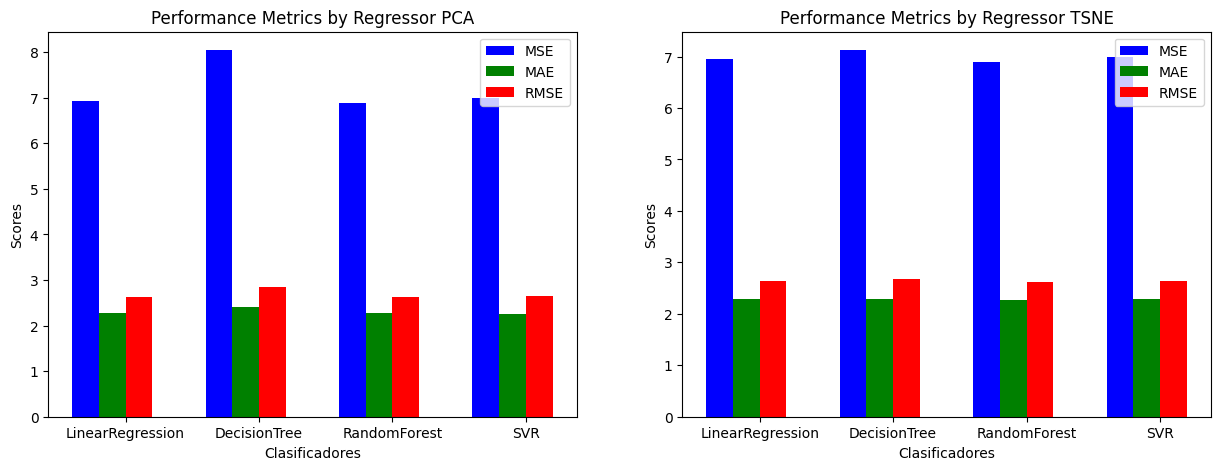

In [60]:
#@title Grafica Comparativa Regresion

classifiers = list(metrics3.keys())
mse = [metrics3[clf]['mse'] for clf in classifiers]
mae = [metrics3[clf]['mae'] for clf in classifiers]
rmse = [metrics3[clf]['rmse'] for clf in classifiers]

classifiers2 = list(metrics4.keys())
mse2 = [metrics4[clf]['mse'] for clf in classifiers2]
mae2 = [metrics4[clf]['mae'] for clf in classifiers2]
rmse2 = [metrics4[clf]['rmse'] for clf in classifiers2]

x = np.arange(len(classifiers))
x2 = np.arange(len(classifiers2))

width = 0.2

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.bar(x - 1.5*width, mse, width, label='MSE', color='blue')
plt.bar(x - 0.5*width, mae, width, label='MAE', color='green')
plt.bar(x + 0.5*width, rmse, width, label='RMSE', color='red')
plt.xlabel('Clasificadores')
plt.ylabel('Scores')
plt.title('Performance Metrics by Regressor PCA')
plt.xticks(x, classifiers)
plt.legend()

plt.subplot(122)
plt.bar(x2-1.5*width, mse2, width, label='MSE', color='blue')
plt.bar(x2-0.5*width, mae2, width, label='MAE', color='green')
plt.bar(x2+0.5*width, rmse2, width, label='RMSE', color='red')
plt.xlabel('Clasificadores')
plt.ylabel('Scores')
plt.title('Performance Metrics by Regressor TSNE')
plt.xticks(x2, classifiers2)
plt.legend()

plt.show()


# **Tercer Entrega**

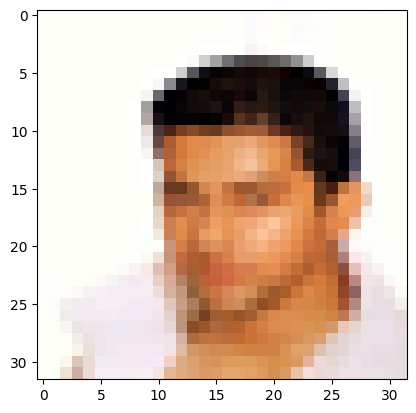

In [62]:
#@title Imagen base

imData=image_data[image_data['id']==100]
imArrayxData = load_images(imData['filename'])
image=Image.fromarray(imArrayxData[7])
image=image.resize((32,32))
plt.imshow(image)
image=np.array(image)

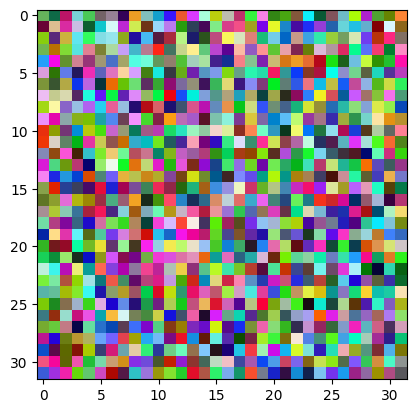

In [63]:
#@title Inicializacion Solucion
np.random.seed(42)
solucion = np.random.randint(0, 256, (32, 32, 3))
plt.imshow(solucion)

In [64]:
#@title Funciones Algoritmo Genetico
def initialize_population(n_individuals, solucion):
    r = []
    for i in range(n_individuals):
        individual = solucion.copy()
        individual = np.random.permutation(individual.reshape(-1)).reshape(solucion.shape)
        r.append(individual)
    return np.array(r)

def cost(imgTruth, imgSolution):
  #Se calcula el mae entre las imagenes
  return np.mean(np.abs(imgTruth - imgSolution))

def crossover(mother, father):
    import random

    height, width, _ = mother.shape

    # se elige un tamaño aleatorio para el subcuadro
    subimage_size = random.randint(1, min(height-2, width-2))

    # se elige aleatoriamente la posición del cuadro subimagen de la madre
    row_start = random.randint(0, height - subimage_size)
    col_start = random.randint(0, width - subimage_size)

    child = np.copy(father)

    # Coloca el subcuadro de la madre en la nueva imagen
    child[row_start:row_start + subimage_size, col_start:col_start + subimage_size,:] = mother[row_start:row_start + subimage_size, col_start:col_start + subimage_size,:]

    return child

def mutate(solution, mutation_prob):
    mutated_solution = np.copy(solution)
    height, width, channels = mutated_solution.shape
    for i in range(height):
      for j in range(width):
        for k in range(channels):
          if np.random.random()<mutation_prob:
              mutated_solution[i,j,k] = np.random.randint(0, 256)
    return mutated_solution

def plot_GA_result(best, bests, means, stds):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    plt.imshow(best)

In [65]:
#@title Implementacion de generaciones
%%writefile ga2.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()


def run_ga2(pop_size, init_population_function,
           mutation_function, crossover_function, cost_function,
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size)
    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in tqdm(range(n_iters)):

        #if i%(n_iters/10)==0:
        # print i

        # do cross over
        offsprings = []
        permut_temp = np.random.permutation(len(pop))
        idx_xover_indivs = permut_temp[n_xover_indivs:]
        #print "permut_temp: ", permut_temp
        #print "idx_xover_indivs: ", idx_xover_indivs
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            offsprings.append(offs)
        offsprings = np.array(offsprings)
        offsprings = offsprings.reshape(offsprings.shape[0], *pop.shape[1:])

        pop = np.concatenate((pop, offsprings), axis=0).astype(int)

        # mutate population
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))

        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)


    return best, best_costs, means, stds

Writing ga2.py


  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

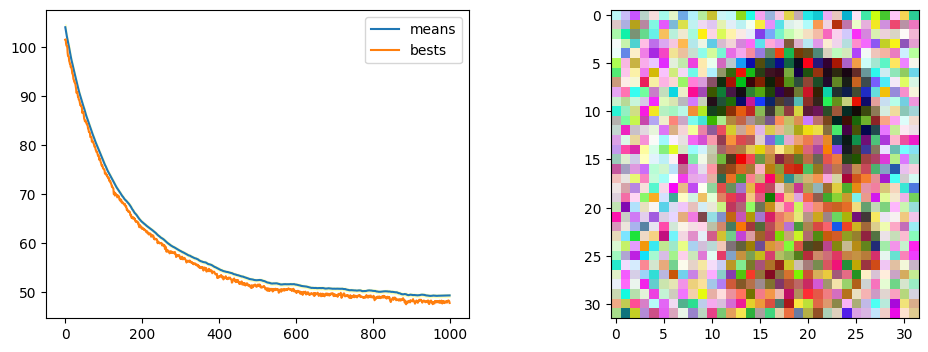

In [66]:
#@title Probando El Algoritmo Generativo
%run ga2.py
r =  run_ga2(pop_size=500,
               init_population_function = lambda x: initialize_population(x, solucion),
               mutation_function        = mutate,
               crossover_function       = crossover,
               cost_function            = lambda x: cost(image, x),
               crossover_prob           = 0.1,
               mutation_prob            = 0.005,
               n_iters                  = 1000)

best, best_costs, means, stds = r
plot_GA_result(best, best_costs, means, stds)

# **Solucion Propuesta**

Con el objetivo de obtener una mejor clasificacion, nuestra propuesta se basa en una red neuronal profunda con el objetivo de mejorar nuestra clasificacion, pero antes debemos solucionar el problema de la cantidad de datos disponibles.

In [5]:
#@title Manipulacion previa de datos
resizedImages=[Image.fromarray(image).resize((32,32)) for image in images_array]
resizedImages=[image.convert('L') for image in resizedImages]
images=np.array(resizedImages)
ids=np.array(image_data['id'])
print(images.shape, ids.shape)

(21152, 32, 32) (21152,)


In [6]:
#@title Data Augmentation
import numpy as np
import cv2

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h))
    return rotated

def translate_image(image, x, y):
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    translated = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return translated

new_images = []
new_ids = []

# Aplicar las transformaciones y almacenar las nuevas imágenes e IDs
for i in range(len(images)):
    original_image = images[i]
    original_id = ids[i]

    # Rotación en tres ángulos diferentes
    rotated_90 = rotate_image(original_image, 90)
    rotated_180 = rotate_image(original_image, 180)
    rotated_270 = rotate_image(original_image, 270)

    # Traslación en tres direcciones diferentes
    translated_x = translate_image(original_image, 5, 0)
    translated_y = translate_image(original_image, 0, 5)
    translated_xy = translate_image(original_image, 5, 5)

    # Agregar las imágenes transformadas y los nuevos IDs a las listas
    new_images.extend([rotated_90, rotated_180, rotated_270, translated_x, translated_y, translated_xy])
    new_ids.extend([original_id] * 6)  # Agregar el ID original para cada transformación

# Convertir las listas a arrays y concatenar con las imágenes e IDs originales
new_images = np.array(new_images)
new_ids = np.array(new_ids)

all_images = np.concatenate((images, new_images), axis=0)
all_ids = np.concatenate((ids, new_ids), axis=0)

print(all_images.shape)
print(all_ids.shape)


(148064, 32, 32)
(148064,)


In [14]:
#@title Normalizacion Y Particion de Datos
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

x_train, x_test, y_train, y_test = train_test_split(all_images, all_ids, test_size=0.2, stratify=all_ids,shuffle=True, random_state=42)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [15]:
#@title Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 1)),  # Forma correcta para imágenes en escala de grises
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(5096, activation='relu'),
    tf.keras.layers.Dense(10192, activation='relu'),
    tf.keras.layers.Dense(5096, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1000, activation='softmax')  # Número de clases (salida de 1000 clases)
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5096)                │      10,441,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 10192)               │      51,948,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 5096)                │      51,943,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 2048)                │      10,438,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1000)                │       1,025,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,437,192 (531.91 MB)

 Trainable params: 139,437,192 (531.91 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#@title Compilando el Modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),  #AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
y_train = y_train - 1
y_test = y_test - 1
history=model.fit(x_train, y_train, epochs=5, batch_size=256)

Epoch 1/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.0013 - loss: 6.8828
Epoch 2/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.0036 - loss: 6.5434
Epoch 3/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.0052 - loss: 6.4082
Epoch 4/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.0058 - loss: 6.3484
Epoch 5/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.0065 - loss: 6.2800


In [18]:
#@title Aplicando un PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
pca_data = pca.fit_transform(all_images.reshape(all_images.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(pca_data, all_ids, test_size=0.2, stratify=all_ids,shuffle=True, random_state=42)

model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(400,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(5096, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1000, activation='softmax')
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
y_train = y_train - 1
y_test = y_test - 1
history=model.fit(X_train, y_train, epochs=100, batch_size=256)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 1024)                │         410,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 5096)                │      10,441,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 2048)                │      10,438,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1000)                │       1,025,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,906,064 (133.16 MB)

 Trainable params: 34,906,064 (133.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0016 - loss: 10.6148
Epoch 2/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.0063 - loss: 6.3144
Epoch 3/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0107 - loss: 5.9991
Epoch 4/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0139 - loss: 5.7603
Epoch 5/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.0187 - loss: 5.5925
Epoch 6/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0206 - loss: 5.4805
Epoch 7/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0231 - loss: 5.3773
Epoch 8/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0267 - loss: 5.2705
Epoch 9/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0297 - loss: 5.1940
Epoch 10/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0319 - loss: 5.1182
Epoch 11/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0347 - loss: 5.0377
Epoch 12/100
463/463 ━━

In [21]:
model.evaluate(X_test, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2208 - loss: 3.5253 


[3.4164693355560303, 0.22371365129947662]